## Center of mass trajectory and analysis

The module vorbilt.com_trajectory contains the COMTraj.py file which defines the COMTraj class that can be used to build a Center of Mass (COM) version of an MDAnalysis trajectory. There are various analyses that can be performed using this type of representation. Some examples that are built in to the module will be demonstrated later in this document. 

To begin we will import the modules we'll use.

In [1]:
#MDAnalysis 0.15.0
import MDAnalysis as mda
#The COMTraj module
from vorbilt.com_trajectory import COMTraj
#Plotting Functions 
%matplotlib inline
import vorbilt.plot_generation.plot_generation_functions as pgf

Now we can construct the MDAnalysis universe object using the test bilayer system provided with VORBILT (located in VORBILT/vorbilt/sample_bilayer).

In [2]:
u = mda.Universe('../vorbilt/sample_bilayer/sample_bilayer.psf','../vorbilt/sample_bilayer/sample_bilayer_10frames.dcd')

Now we need to select the bilayer atoms.


In [3]:
bilayer = u.select_atoms("resname POPC or resname DOPE or resname TLCL2")

And now we can build the COMTraj object.

In [4]:
com_traj = COMTraj.COMTraj(u.trajectory, bilayer)

doing full trajectory frame  0 , COM trajectory frame  0
time  0.0
doing full trajectory frame  1 , COM trajectory frame  1
time  0.04888821
doing full trajectory frame  2 , COM trajectory frame  2
time  0.09777642
doing full trajectory frame  3 , COM trajectory frame  3
time  0.14666463
doing full trajectory frame  4 , COM trajectory frame  4
time  0.19555284


/home/blake/anaconda2/envs/vorbilt/lib/python2.7/site-packages/MDAnalysis/core/AtomGroup.py:477: DeprecationWarning: In version 0.16.0, use `residue.atoms.indices` instead.
  DeprecationWarning)
/home/blake/anaconda2/envs/vorbilt/lib/python2.7/site-packages/MDAnalysis/core/AtomGroup.py:477: DeprecationWarning: In version 0.16.0, use `residue.atoms.masses` instead.
  DeprecationWarning)


doing full trajectory frame  5 , COM trajectory frame  5
time  0.24444105
doing full trajectory frame  6 , COM trajectory frame  6
time  0.29332926
doing full trajectory frame  7 , COM trajectory frame  7
time  0.34221747
doing full trajectory frame  8 , COM trajectory frame  8
time  0.39110568
doing full trajectory frame  9 , COM trajectory frame  9
time  0.43999389


In [5]:
print(com_traj)

Center of mass trajectory with 10 frames and 600 lipids/components


The COMTraj initializer reqiures the MDAnalysis trajectory object and an atom selection object. There are some optional keyword arguments, such as 'frame_path', which can can set. 'frame_path' defines a non-default location where the COM trajectory data will be stored on disk. The com trajectory can be left saved on disk after the session by also setting the 'frame_save' flag to True. 

By default the the xy plane is assumed to be the lateral dimension of the bilayer, and the z direction is assumed to be along the bilayer normal. However, these can be specified at initialization via the 'plane' input variable string if your bilayer has a different orientation. 

In [6]:
# Re-initialize, but specify the lateral plane
com_traj_b = COMTraj.COMTraj(u.trajectory, bilayer, plane='xy')

doing full trajectory frame  0 , COM trajectory frame  0
time  0.0
doing full trajectory frame  1 , COM trajectory frame  1
time  0.04888821
doing full trajectory frame  2 , COM trajectory frame  2
time  0.09777642
doing full trajectory frame  3 , COM trajectory frame  3
time  0.14666463
doing full trajectory frame  4 , COM trajectory frame  4
time  0.19555284
doing full trajectory frame  5 , COM trajectory frame  5
time  0.24444105
doing full trajectory frame  6 , COM trajectory frame  6
time  0.29332926
doing full trajectory frame  7 , COM trajectory frame  7
time  0.34221747
doing full trajectory frame  8 , COM trajectory frame  8
time  0.39110568
doing full trajectory frame  9 , COM trajectory frame  9
time  0.43999389


The options for specifying the lateral plane are 'xy' (the default), 'yz', and 'xz', or their equivalents 'yx', 'zy', and 'zx'. 

#### Frames
The COMTraj object is composed of COM 'Frame' objects stored in a specialized 'FrameShelve' container under the 'frame' member variable.

In [7]:
print(com_traj.frame)
print(com_traj.frame[0])

<vorbilt.com_trajectory.COMTraj.FrameShelve instance at 0x7fee3c14e320>
<vorbilt.com_trajectory.COMTraj.Frame instance at 0x7fee3d3a2998>


The FrameShelve object stores the COM Frame's of the trajectory on disc using the Shelve module (https://docs.python.org/2/library/shelve.html). We can check the number of frames stored in the object either by accessing the 'nframes' member variable of the com_traj instance or by using len on the 'frame' variable.

In [8]:
print(com_traj.nframes)
print(len(com_traj.frame))

10
10


Individual frames can accessed by indexing the 'com_traj.frame' variable.

In [9]:
print com_traj.frame[0]

<vorbilt.com_trajectory.COMTraj.Frame instance at 0x7fee3c15a098>


In [10]:
#len returns the number COMs (or lipids) in the Frame instance.
print len(com_traj.frame[0])

600


Although the frames can be indexed individully, there are some built in analyses that automatically handle looping over frames and doing their specific computations. However, there are times when indexing the frames is necessary, such as in defining custom analyses. 

#### Leaflets
The next major component of the COMTraj class instance is the 'leaflets' member variable. This is a dictionary with two keys: 'upper' and 'lower'. 

In [11]:
print com_traj.leaflets

{'upper': upper leaflet of a Center of mass trajectory with 300 members and 3 lipid groups, 'lower': lower leaflet of a Center of mass trajectory with 300 members and 3 lipid groups}


When the COMTraj class instance is initialized it automatically uses the first frame to sort the lipids into an 'upper' and 'lower' leaflet. 

###### Note:
The average position along the bilayer normal is currently used to divide the leaflets, so if you are working with highly curved bilayers this process will likely be inaccurate (functionality to handle this problem is the topic of future development). 

The indivdiual leafleat objects stored in the dictionary contain information about the number of lipids in that leaflet, as well as the types of lipids (assigned by their MDAnalysis resname). 

In [12]:
#Access the 'upper' leaflet
print com_traj.leaflets['upper']

upper leaflet of a Center of mass trajectory with 300 members and 3 lipid groups


In [13]:
# Check the types of lipids in that leaflet
print com_traj.leaflets['upper'].get_group_names()

['POPC', 'TLCL2', 'DOPE']


The leaflets construct allows many analyses, such as Mean Squared Displacement (MSD), to be performed on a per leaflet level. The grouping construct stored in the leaflet then allows for per lipid type analysis. 

#### Example anlysis- Mean Squared Displacement (MSD)
As an example let's go ahead and look at computing some MSDs. 

In [14]:
# compute the global MSD (2d MSD in the lateral dimensions of the bilayer)
msd_global = com_traj.calc_msd()
print msd_global

[[ 0.          0.        ]
 [ 0.04888821  0.57014543]
 [ 0.09777642  0.83566515]
 [ 0.14666463  0.9216467 ]
 [ 0.19555284  1.11987873]
 [ 0.24444105  1.32089826]
 [ 0.29332926  1.55354826]
 [ 0.34221747  1.91665934]
 [ 0.39110568  2.10194152]
 [ 0.43999389  2.35802145]]


The calc_msd function returns a nframesx2 numpy array of the time series MSD values. The left column is the simulation time and the right is the MSD value (averaged over all the lipids, no time averaging).
Now we can take advantage of the leaflet and grouping structure to compute the MSD of specific groupings of the lipids.

In [15]:
#MSD for the upper leaflet
msd_upper = com_traj.calc_msd(leaflet='upper')
#MSD for the lower leaflet
msd_lower = com_traj.calc_msd(leaflet='lower')
#MSD for POPC (in both leaflets)
msd_popc = com_traj.calc_msd(group='POPC')
#MSD for DOPE in the upper leaflet
msd_dope_upper = com_traj.calc_msd(leaflet='upper', group='DOPE')

Now let's plot these data. We'll use the template plotting function 'plot_msd' in plot_generation_functions.

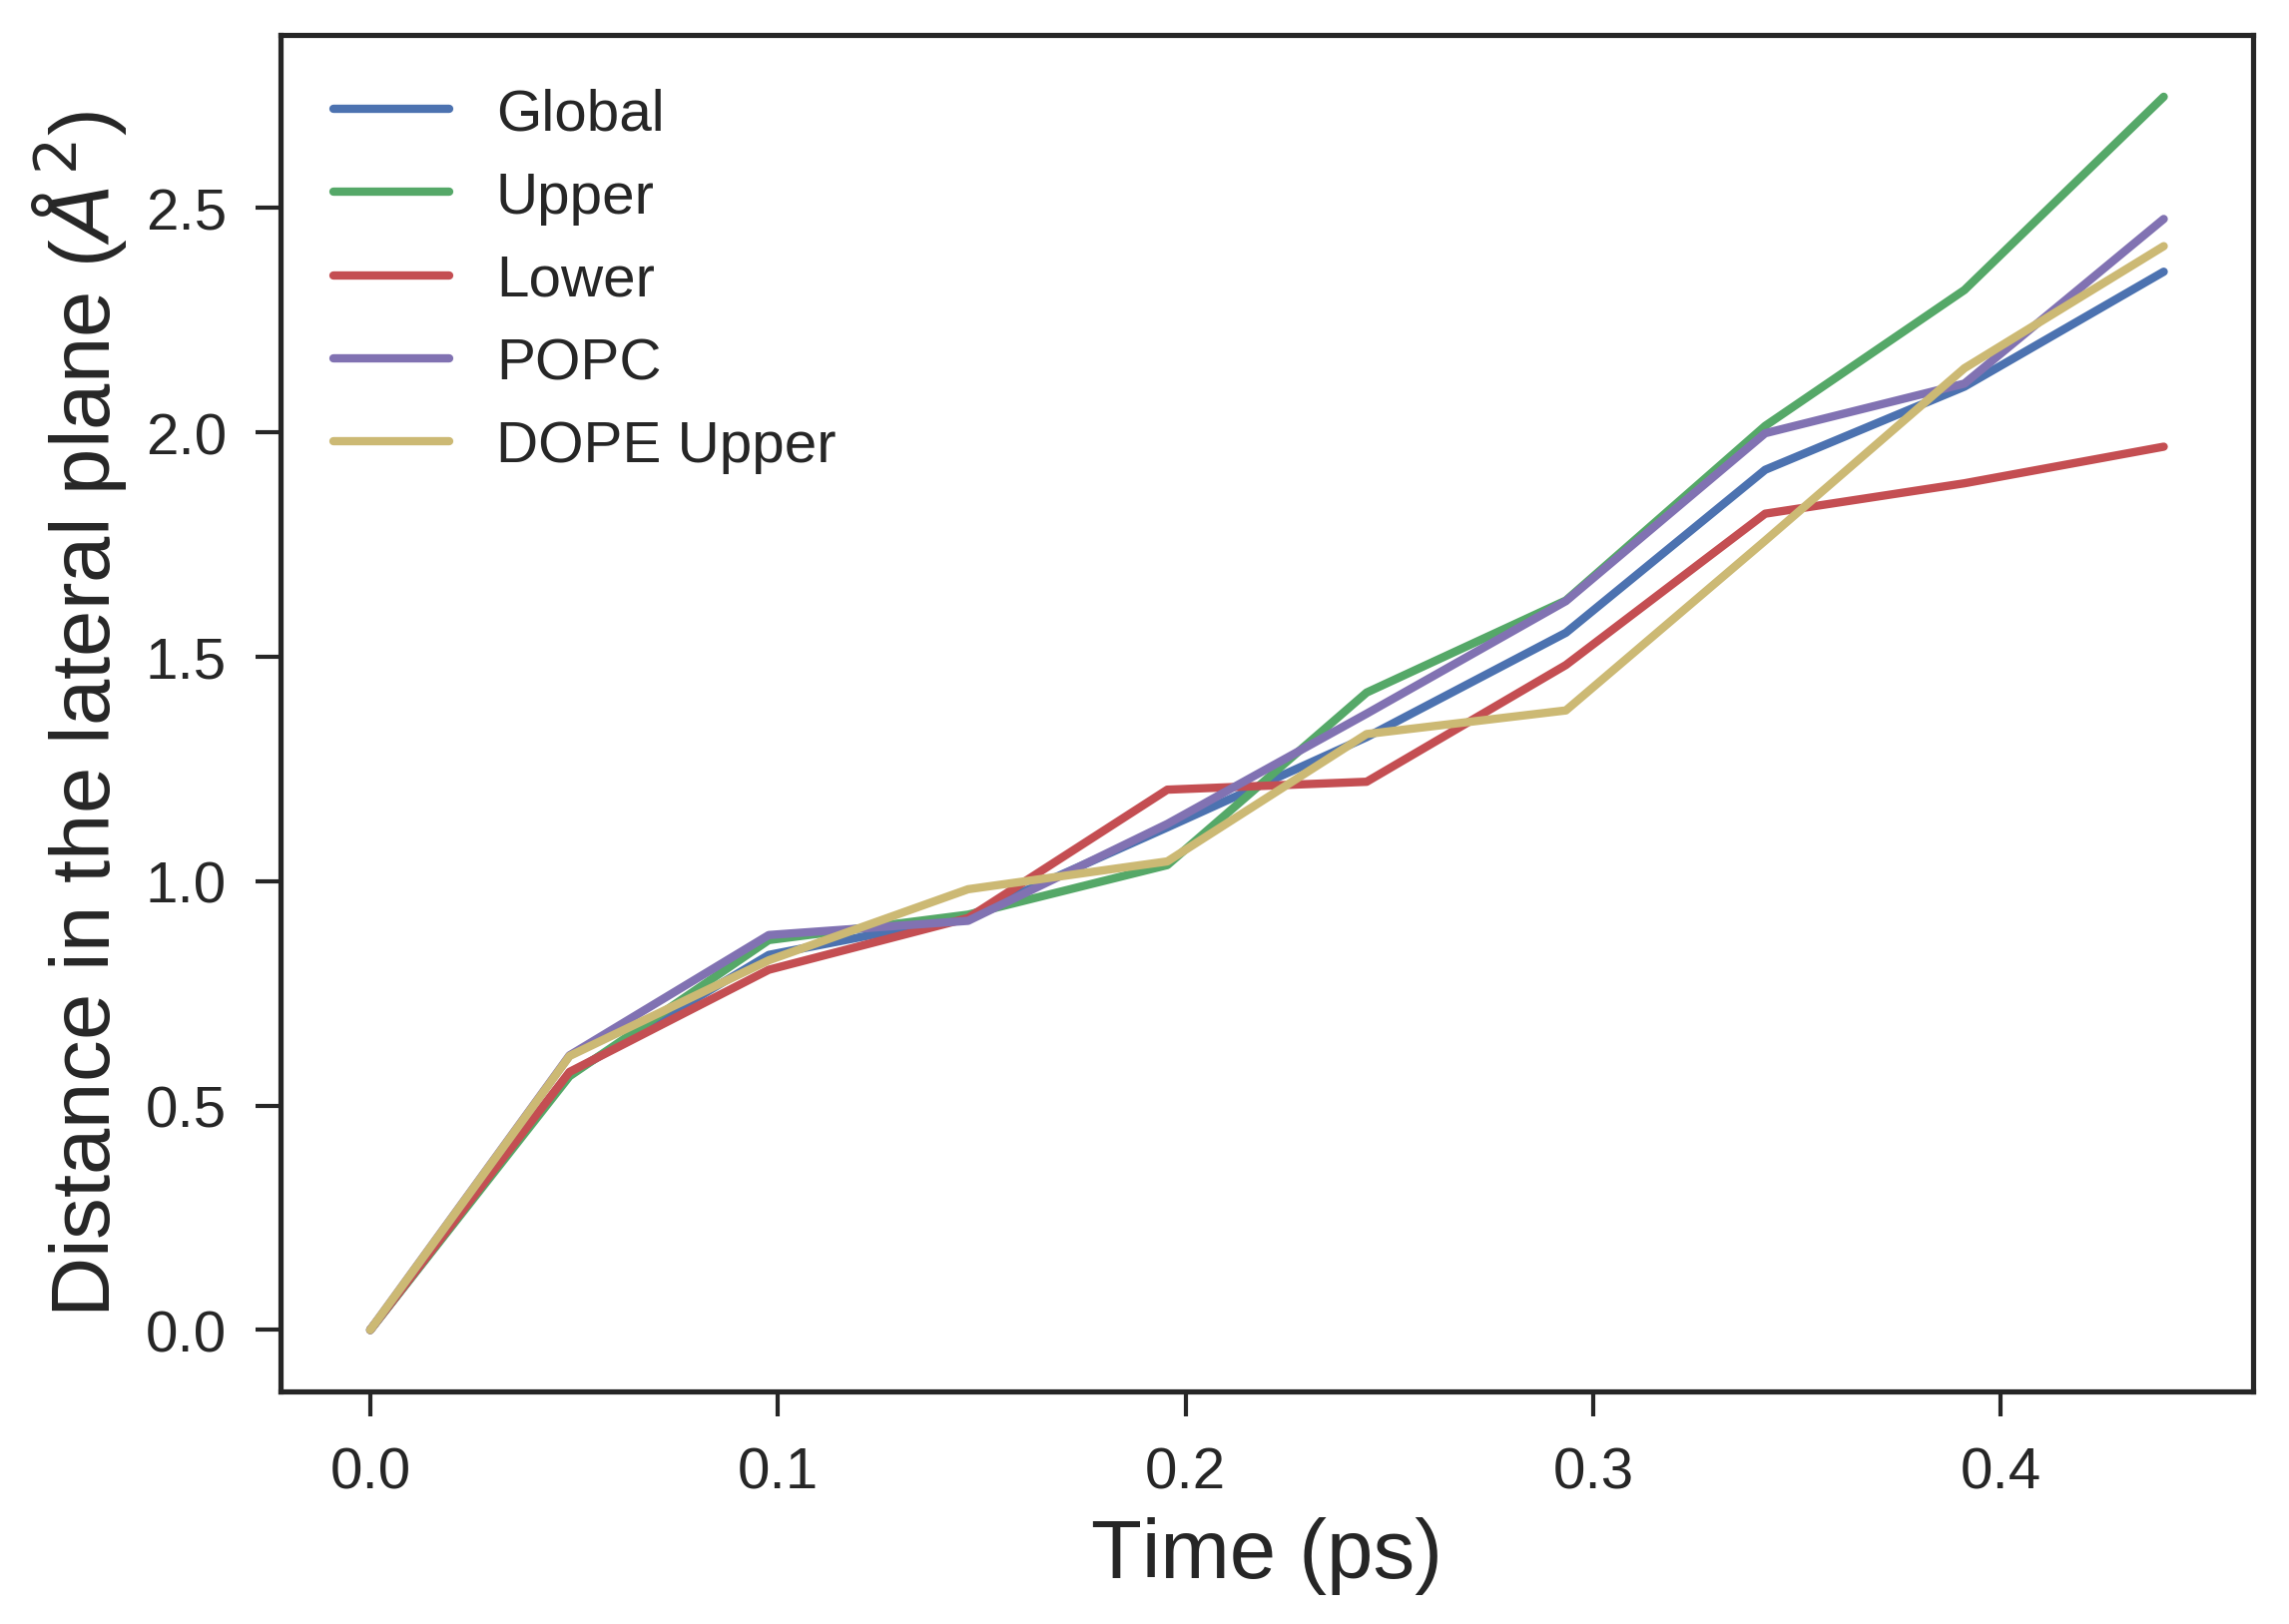

In [16]:
#plot the MSD data
pgf.plot_msd([msd_global, msd_upper, msd_lower, msd_popc, msd_dope_upper], 
             name_list=['Global','Upper','Lower','POPC','DOPE Upper'],
             show=True, save=False, time_out='ps')

There is also a multithreaded version of the MSD computation that is provided. This version parallelizes the loop over the frames, so is very helpful when the trajectory is large and their are a lot frames.

In [17]:
#compute MSD for POPC using multithreaded version
print(COMTraj.msd_frames)
msd_popc_mt = com_traj.calc_msd_parallel(group='POPC', nprocs=2)

<function msd_frames at 0x7fee5338d050>


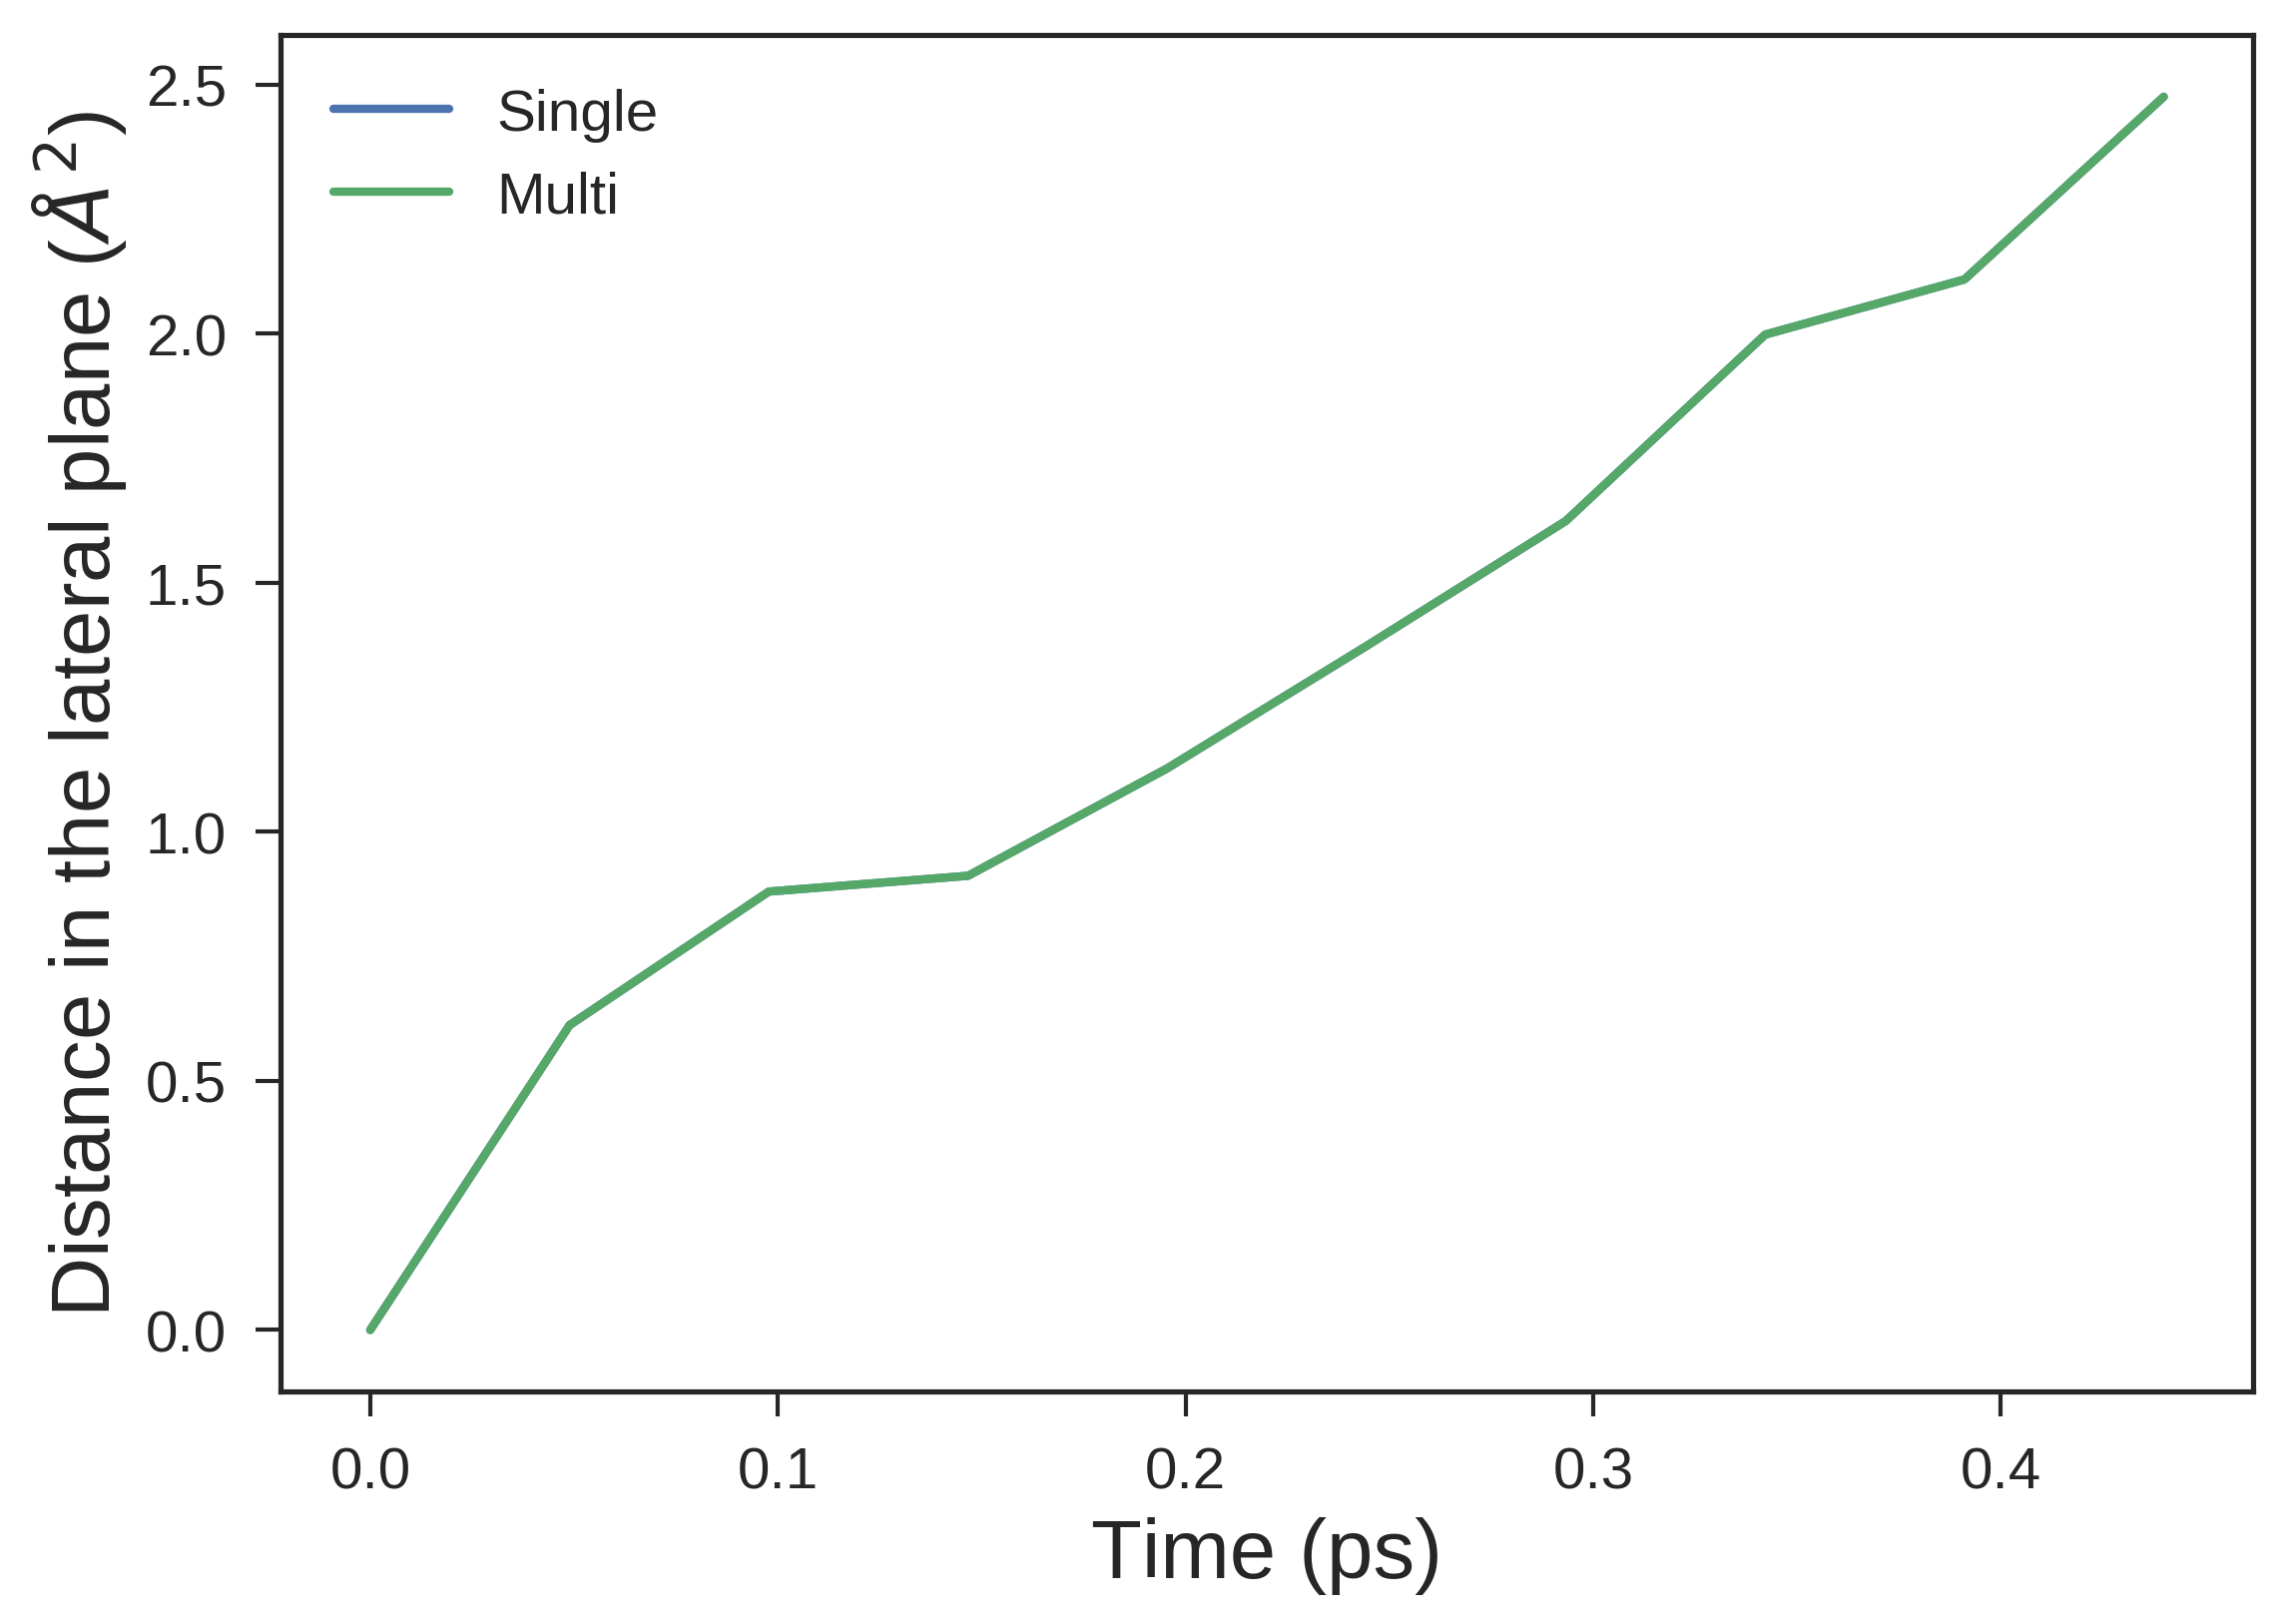

In [18]:
#Now plot
pgf.plot_msd([msd_popc, msd_popc_mt], name_list=['Single','Multi'], time_out='ps', save=False, show=True)

#### Examples of some other included anlayses

##### Area Per Lipid
The COMTraj class object has two built-in estimators of the area per lipid. One simply uses the box size data from the trajectory and the number of lipids to estimate the area per lipid, which is accurate for homogenous bilayers. 

In [19]:
#Area per lipid using box size
apl_box = com_traj.calc_area_per_lipid_box(leaflet="both")

In [20]:
print(apl_box)

[[  0.00000000e+00   7.42801931e+01   7.42801931e+01   0.00000000e+00]
 [  4.88882100e-02   7.44916480e+01   7.43859205e+01   1.49521247e-01]
 [  9.77764200e-02   7.41724311e+01   7.43147574e+01   1.62391147e-01]
 [  1.46664630e-01   7.41914761e+01   7.42839371e+01   1.46219549e-01]
 [  1.95552840e-01   7.43717284e+01   7.43014953e+01   1.32576697e-01]
 [  2.44441050e-01   7.45077683e+01   7.43358742e+01   1.45439635e-01]
 [  2.93329260e-01   7.42973232e+01   7.43303669e+01   1.33564782e-01]
 [  3.42217470e-01   7.43610013e+01   7.43341962e+01   1.24130383e-01]
 [  3.91105680e-01   7.43570966e+01   7.43367407e+01   1.16363989e-01]
 [  4.39993890e-01   7.45120268e+01   7.43542693e+01   1.22917010e-01]]


However, for heterogeneous bilayers it is effectively the composite average over all lipid types, and doesn't give us any information about the area occupied by a specific lipid type.

Therefore a another estimator is provided that allows us to do the calculation by lipid type, and although this function is a more expensive computation, it allows for a rough estimation of per lipid type values.  

In [21]:
#Area per lipid using nearest neighbor distances
apl_nnd = com_traj.calc_area_per_lipid_closest_neighbor_circle(leaflet="both", group="all")

In [22]:
#Area per lipid for POPC
apl_nnd_popc = com_traj.calc_area_per_lipid_closest_neighbor_circle(leaflet="both", group="POPC")
#Area per lipid for DOPE
apl_nnd_dope = com_traj.calc_area_per_lipid_closest_neighbor_circle(leaflet="both", group="DOPE")

Let's plot the values for comparison.

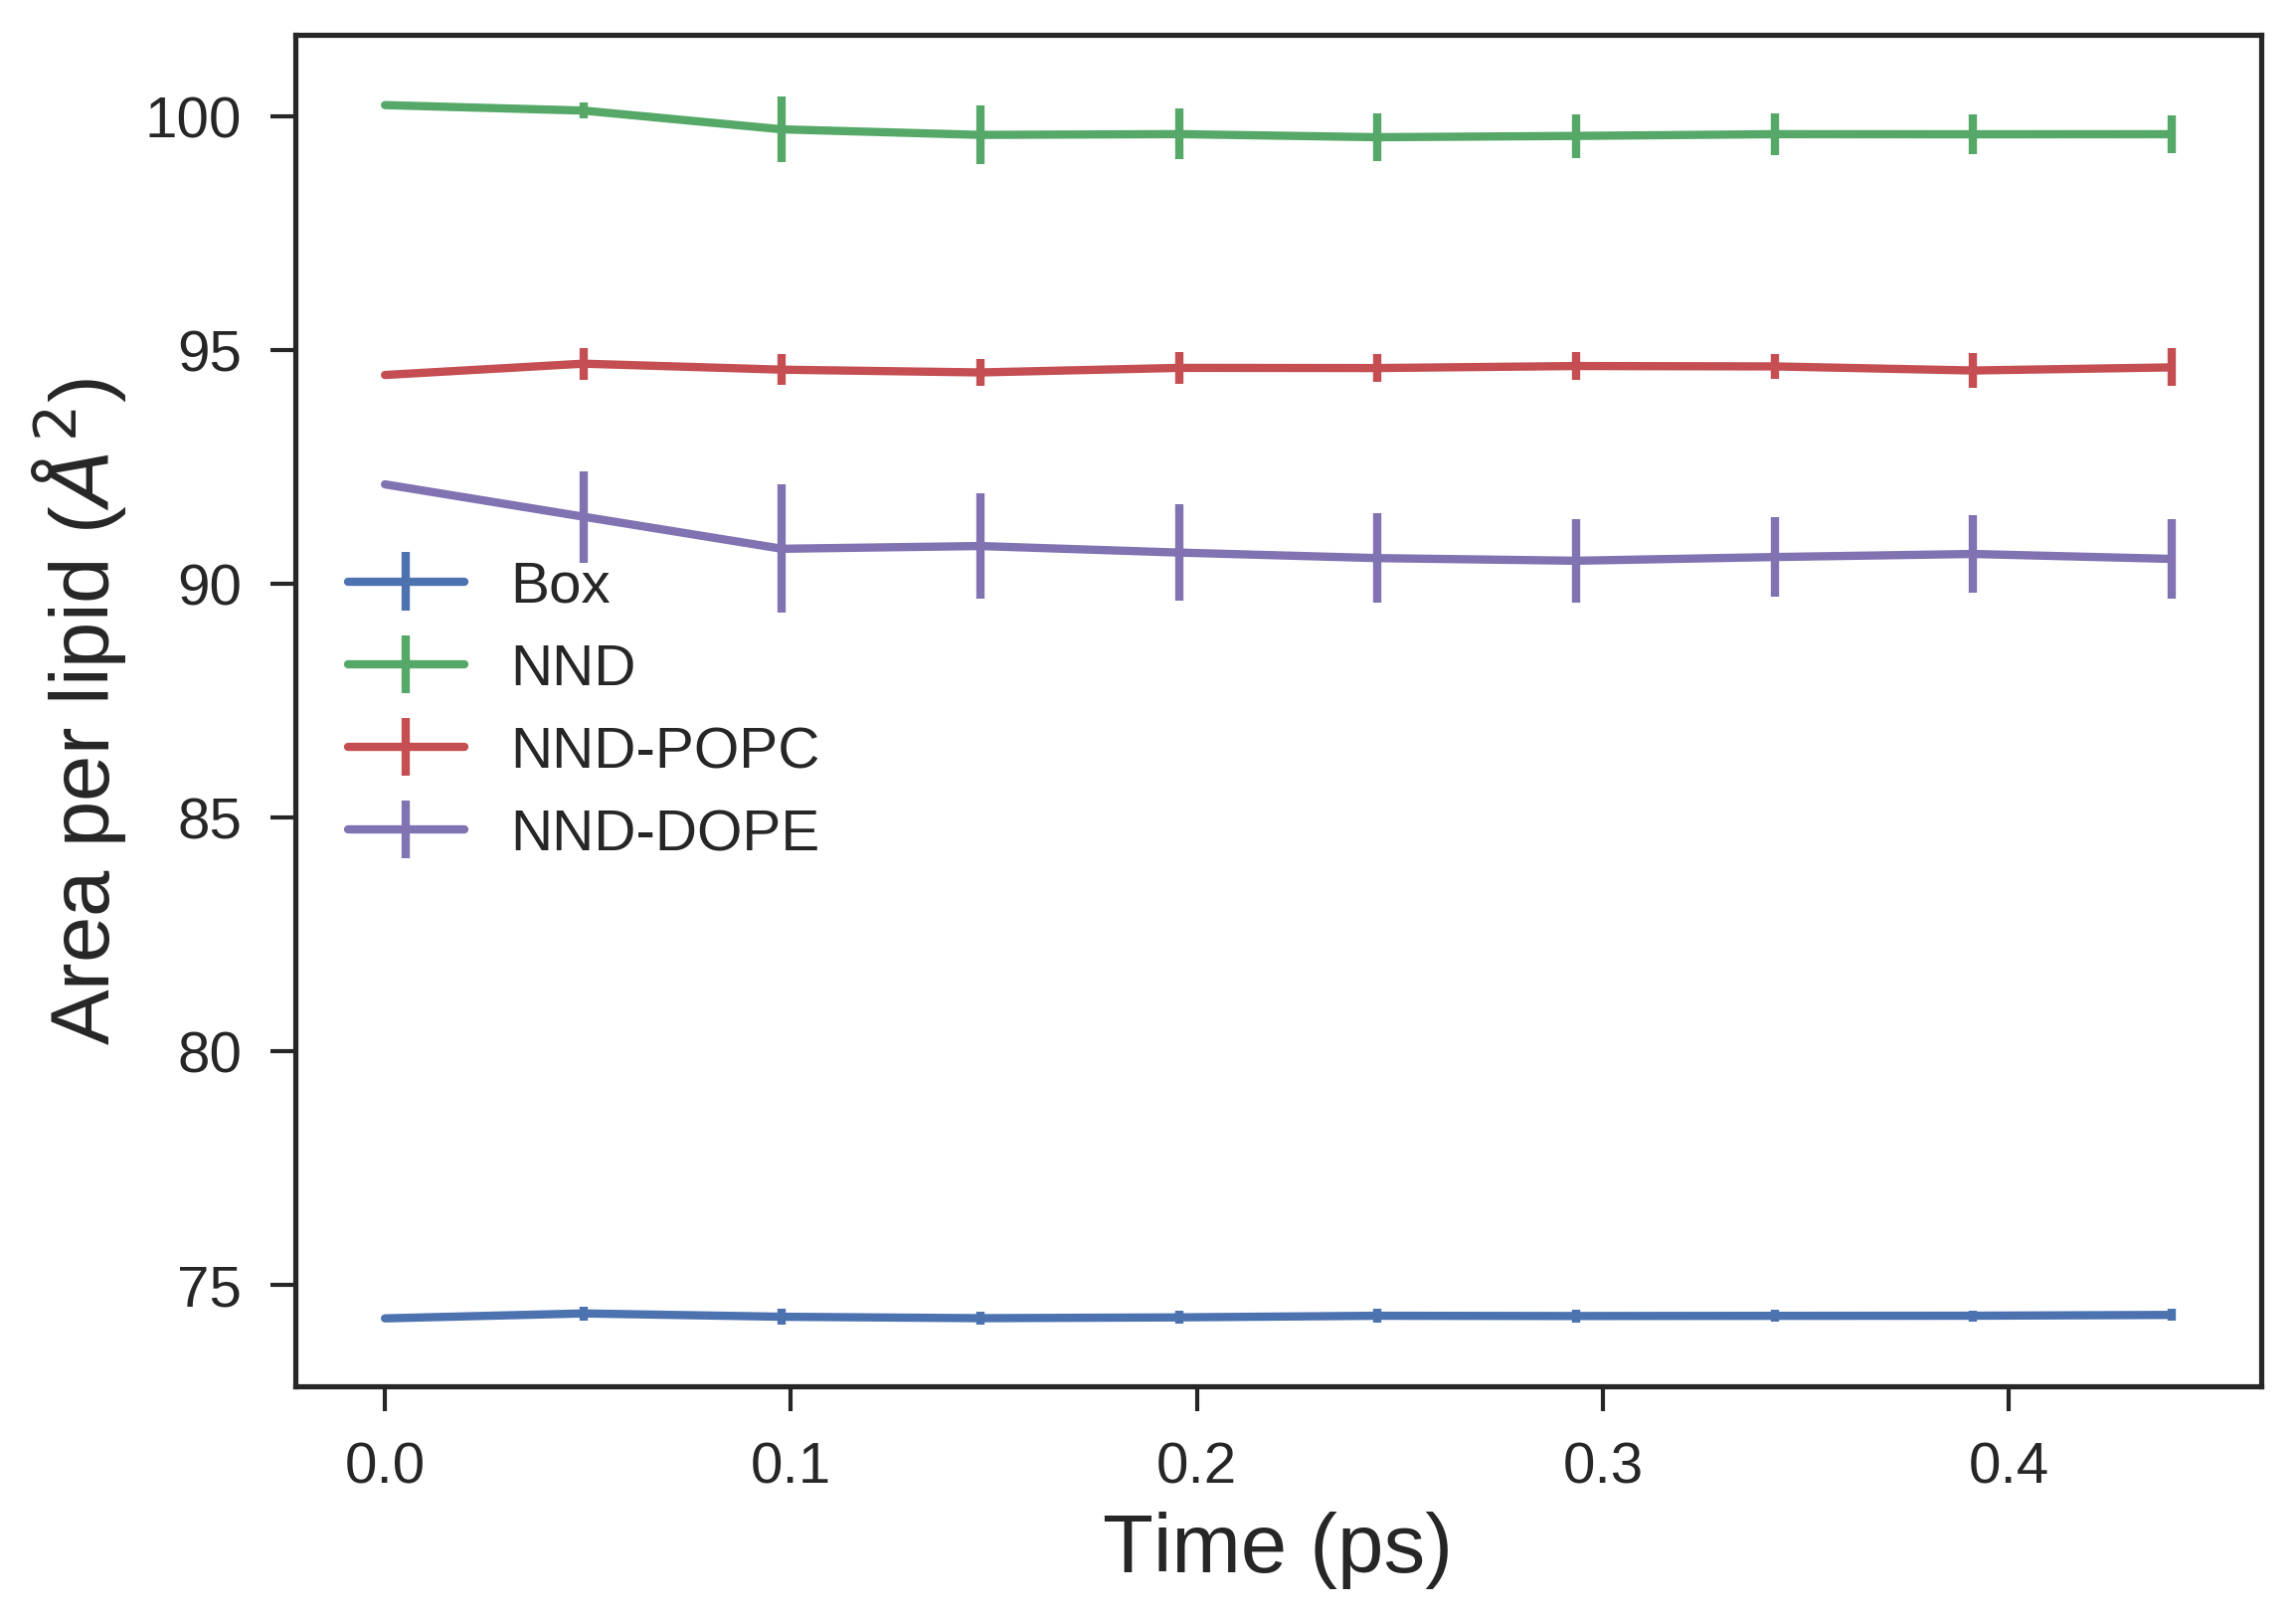

In [23]:
#Plot using template function
pgf.plot_area_per_lipid([apl_box,apl_nnd,apl_nnd_popc, apl_nnd_dope],name_list=['Box','NND','NND-POPC','NND-DOPE'], time_out='ps',show=True, save=False)

For more accurate area per lipid estimations we reccommend using the gridding objects in the vorbilt.leaflet_gridding module files. 

##### Step/Displacement Vectors and Flow Maps

Another type of analysis/visualization we can do is create flow maps, which are constructed from displacements of the lipid COMs over intervals of time. This analysis is based on the work of Falck et al. (http://pubs.acs.org/doi/abs/10.1021/ja7103558).

In [24]:
#compute the displacement vectors (in the lateral dimension) of the upper leaflet
disp_vecs = com_traj.step_vector(leaflet='upper',group='all',fstart=0,fend=-1,fstep=2,wrapped=False)
#get the colors to use for plotting
disp_vec_colors = com_traj.step_vector_colors(leaflet='upper', group='all')

'disp_vecs' is a list of data needed to produce the flow map. The length of the list is the number of intervals computed. 

In [25]:
print(len(disp_vecs))

4


In [26]:
print(disp_vecs[0])

[[ -0.14125526   4.12947139  -1.19199     -0.64882991]
 [ -4.09419135  10.51957597   0.85952306   0.11020866]
 [  8.07438791  -2.31697149  -0.72596856   1.06088139]
 ..., 
 [-73.91733114  55.07309012  -0.2282957   -0.38001494]
 [ 65.48004155  71.13093549  -0.43539311   0.27611566]
 [-61.20509723 -73.84297307  -0.51082064   0.10892904]]


In [27]:
print(disp_vec_colors)

(array([[  5.00000000e-01,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00],
       [  5.00000000e-01,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00],
       [  5.00000000e-01,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00],
       ..., 
       [  1.00000000e+00,   1.22464680e-16,   6.12323400e-17,
          1.00000000e+00],
       [  1.00000000e+00,   1.22464680e-16,   6.12323400e-17,
          1.00000000e+00],
       [  1.00000000e+00,   1.22464680e-16,   6.12323400e-17,
          1.00000000e+00]]), {'POPC': array([ 0.5,  0. ,  1. ,  1. ]), 'TLCL2': array([ 0.50392157,  0.99998103,  0.70492555,  1.        ]), 'DOPE': array([  1.00000000e+00,   1.22464680e-16,   6.12323400e-17,
         1.00000000e+00])})


The 'disp_vec_colors' variable is a two element tuple. The first element are the color codes associated with each vector in the flow map we will generate, while the second element is a dictionary of lipid types and the color code associated with that lipid type. 

Now lets make a plot of one of the flows.

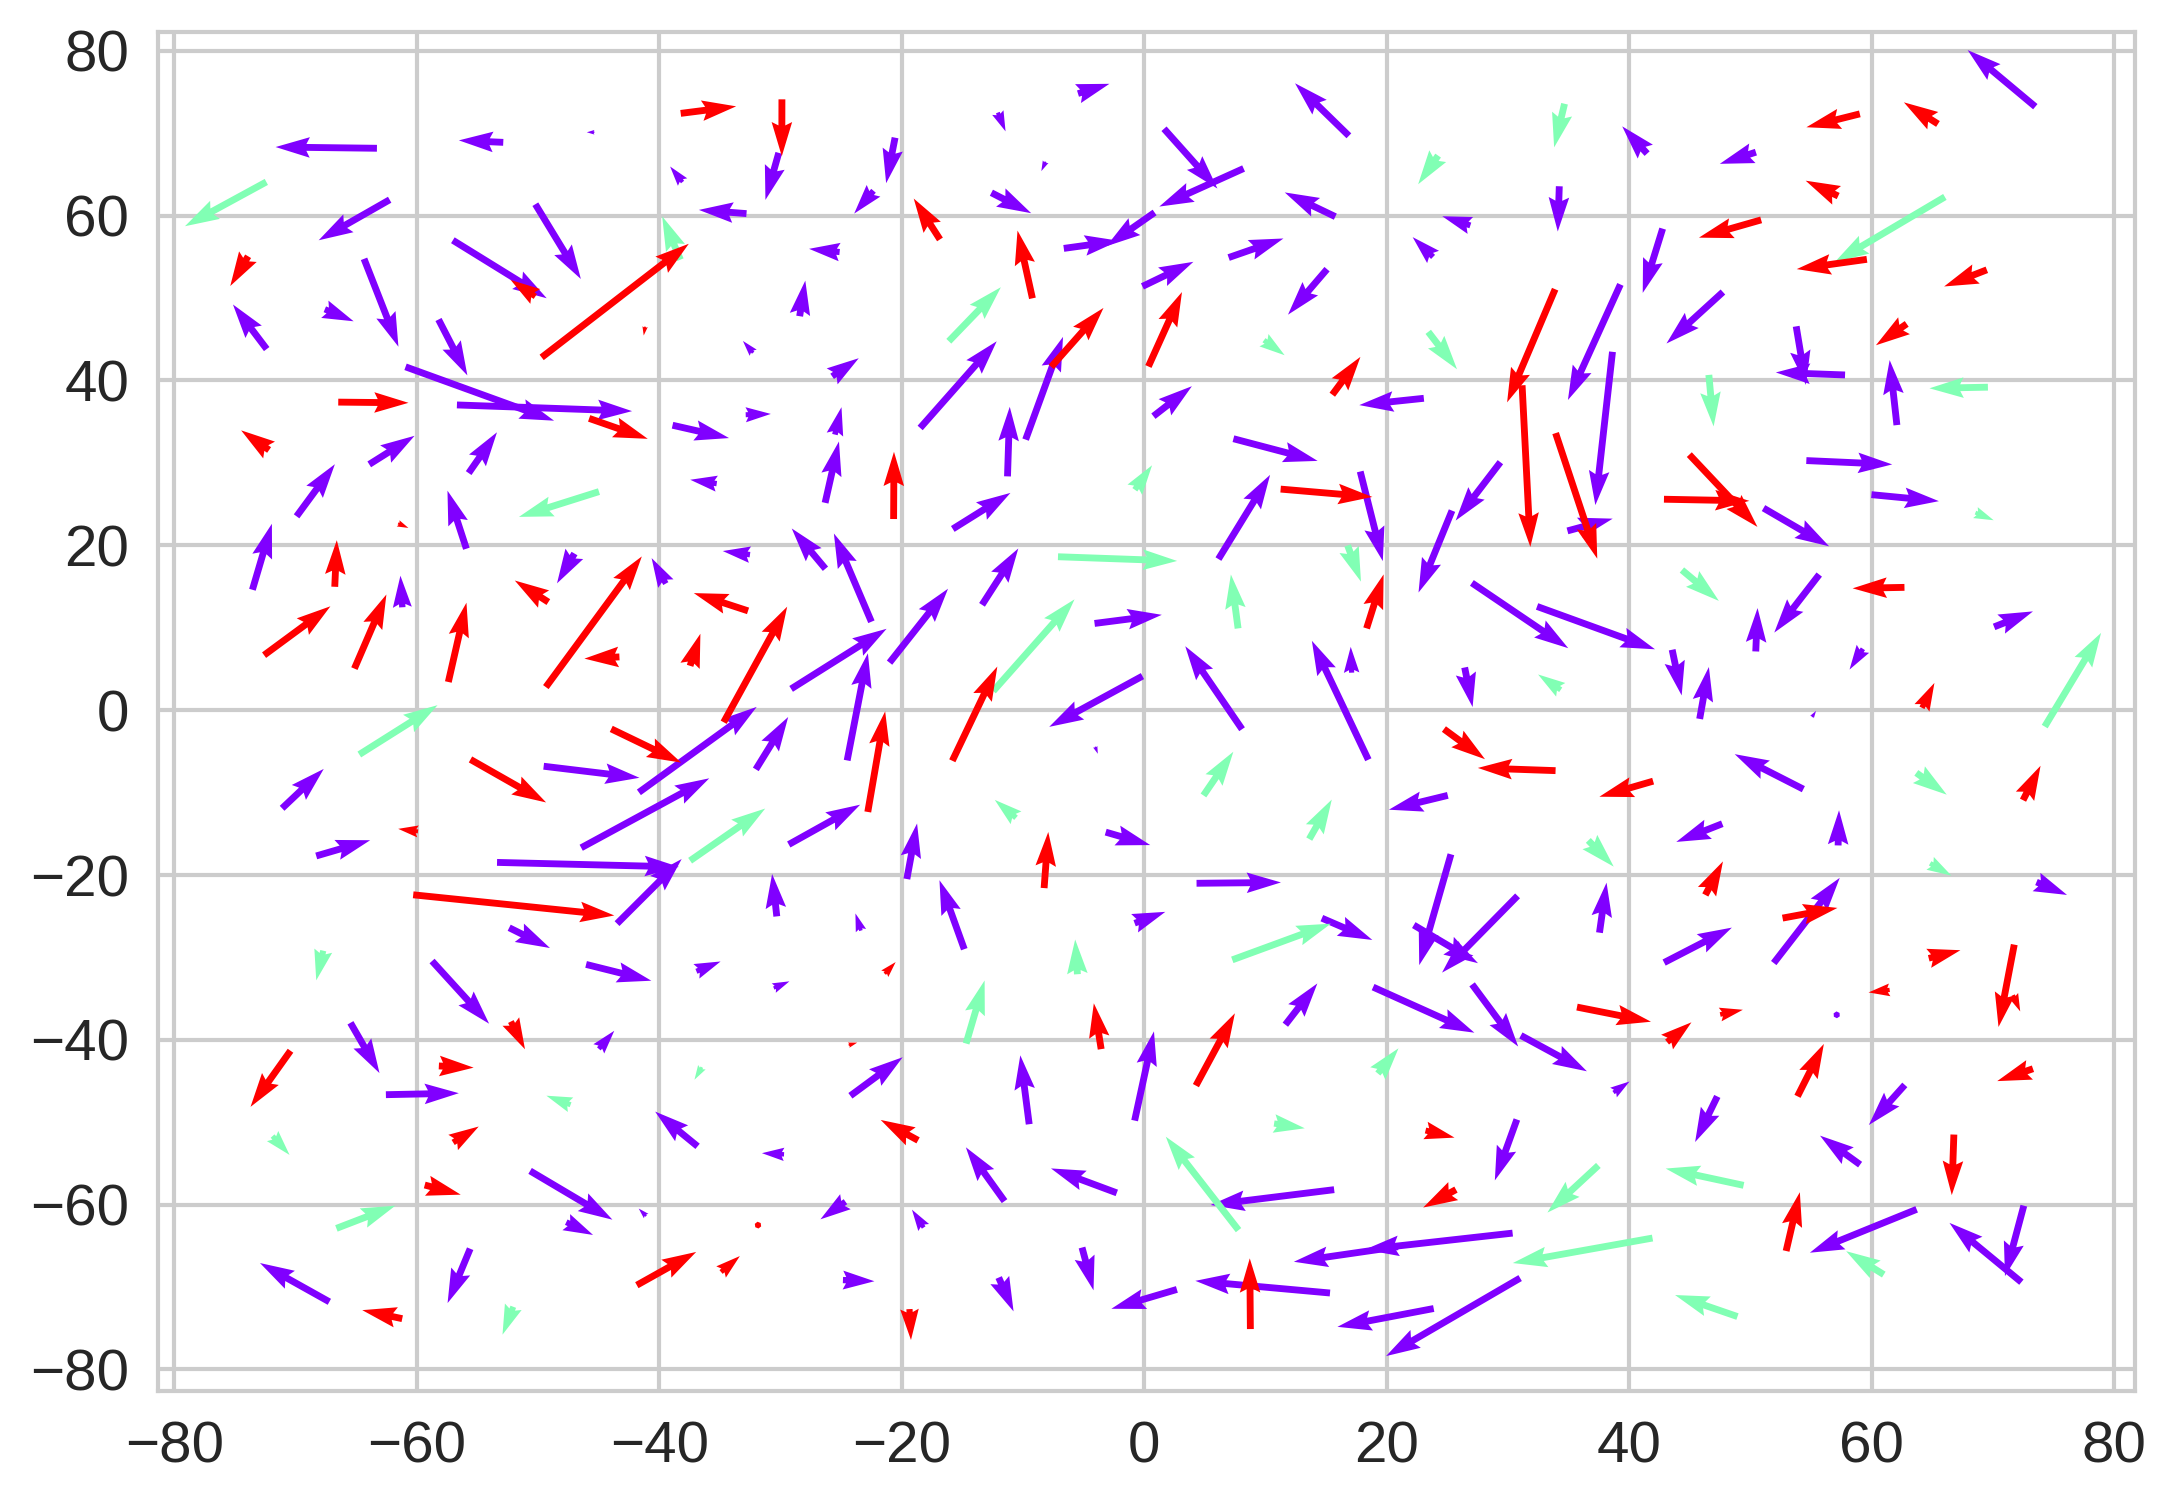

In [29]:
# we need to pass one element of the list, along with the colors.
pgf.plot_step_vectors_comtraj(disp_vecs[0], colors=disp_vec_colors[0], save=False, show=True)

And now we generate the flow map for the next interval:

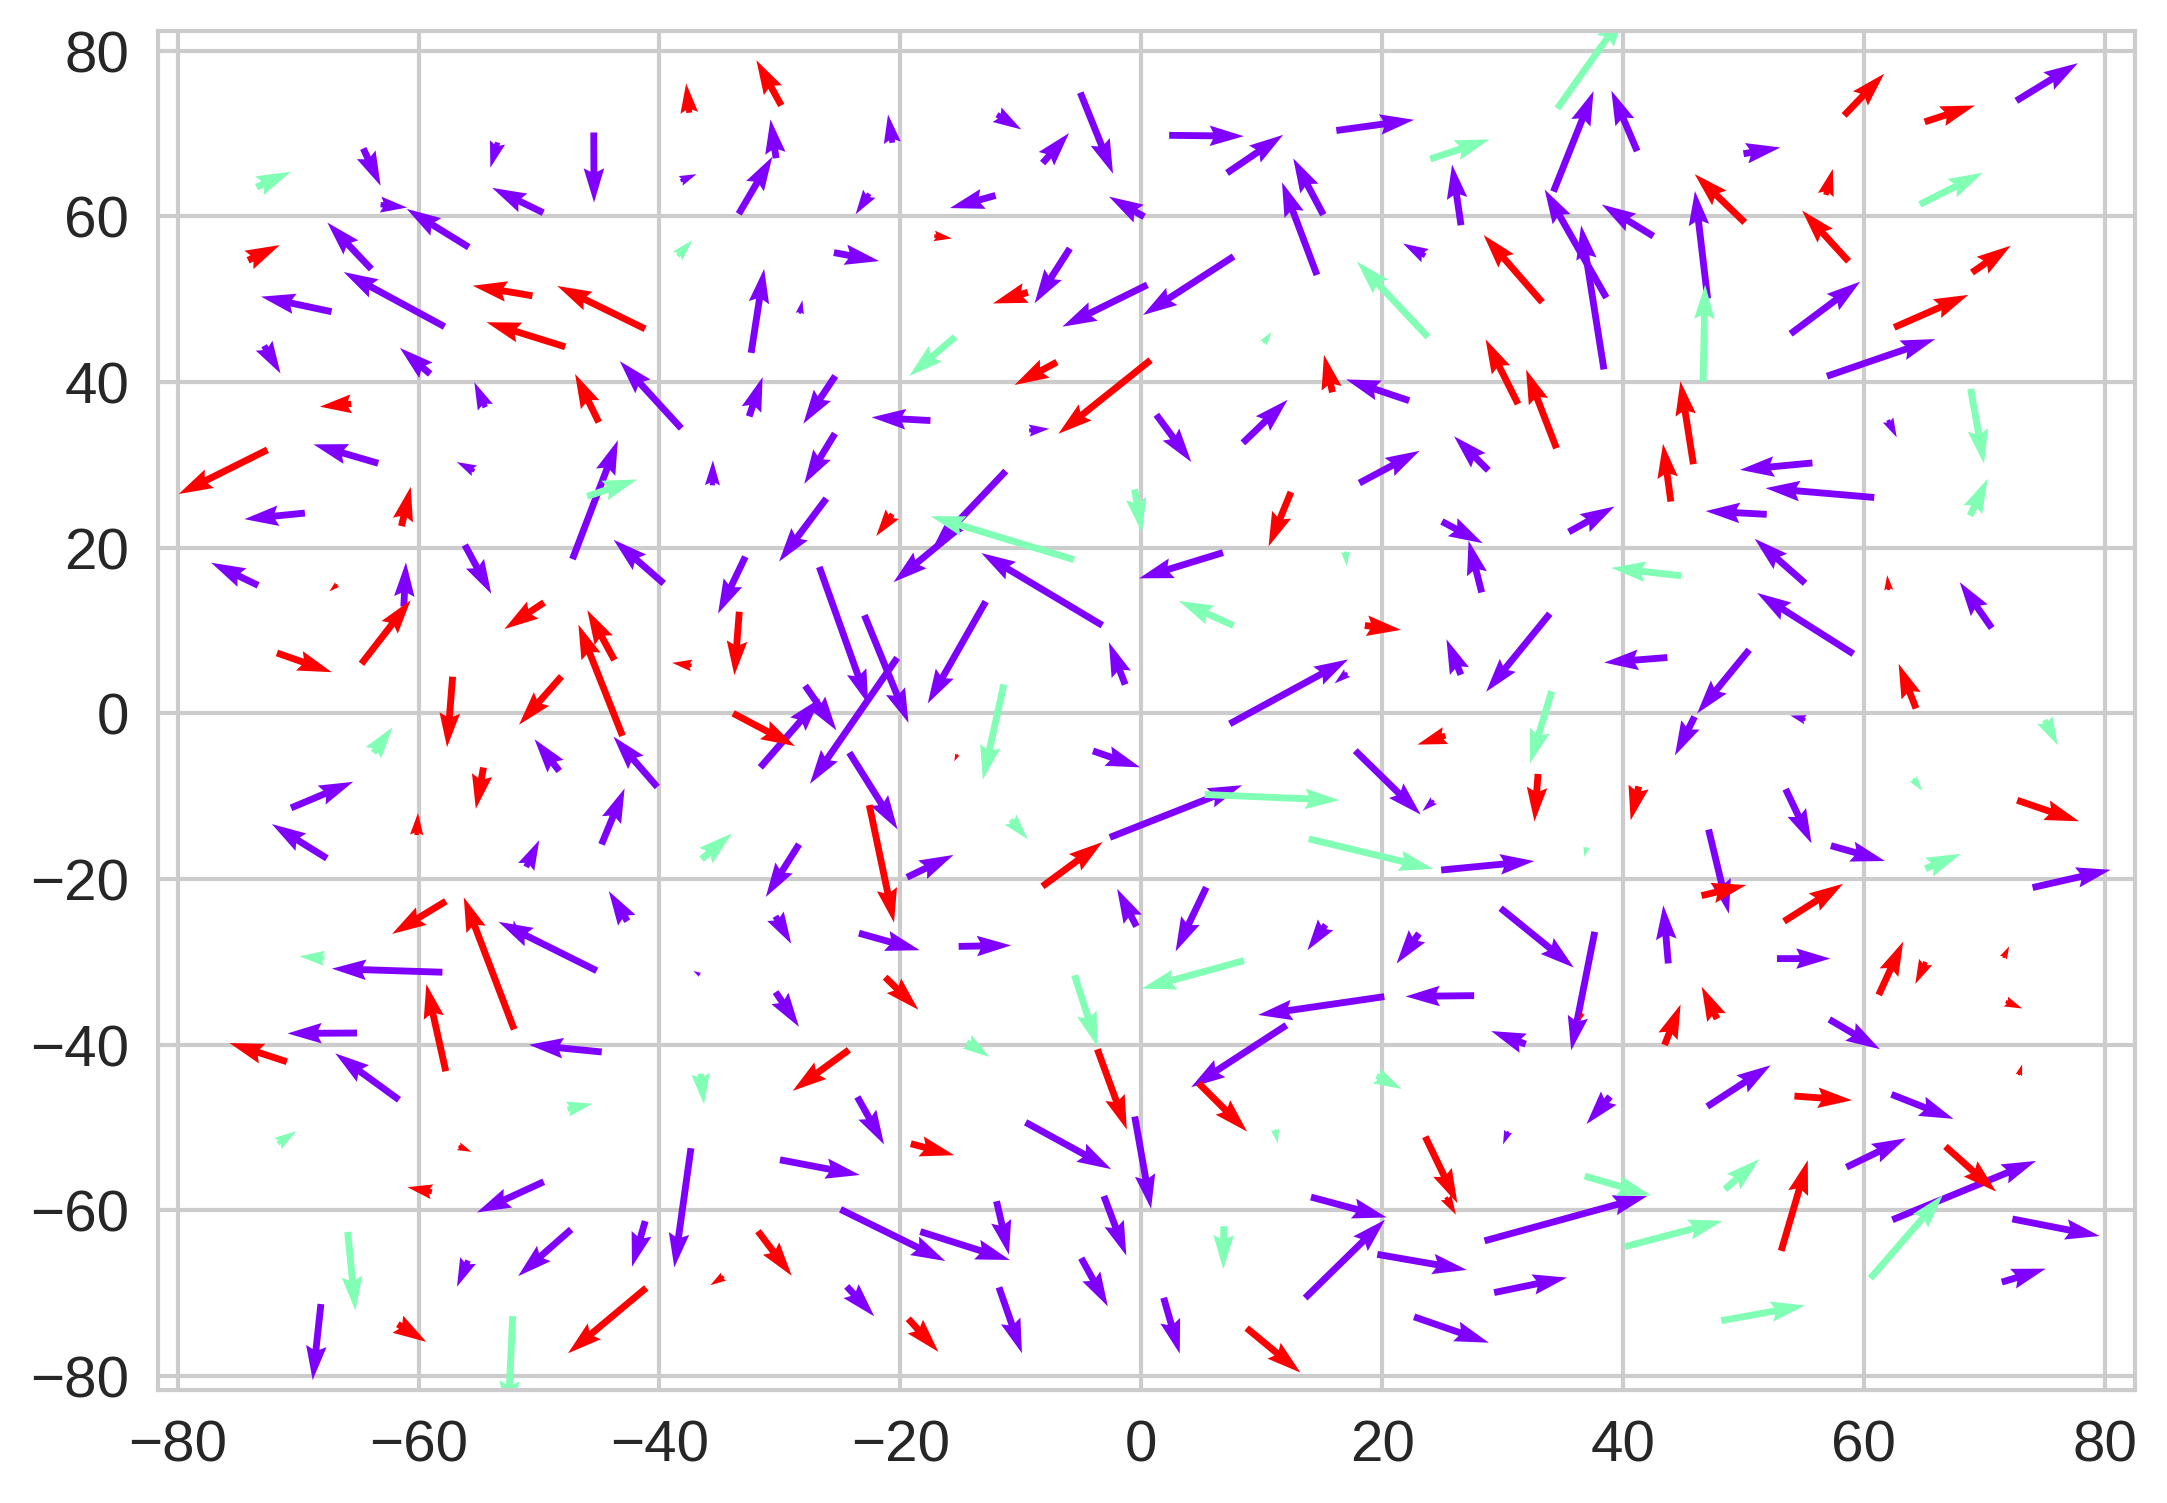

In [30]:
# we need to pass one element of the list, along with the colors.
pgf.plot_step_vectors_comtraj(disp_vecs[1], colors=disp_vec_colors[0], save=False,show=True)